In [45]:
import pandas as pd
from sklearn.metrics import r2_score
import suncalc

from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler


In [46]:
training_set = pd.read_csv("training.csv")
test_set = pd.read_csv("test_students.csv")
x = training_set.drop(['solar_production'], axis=1).copy()
y = training_set['solar_production'].copy()

In [47]:
x['Date'] = pd.to_datetime(x['Date'])
x.sort_values(by='Date', ascending=True)
x['Date'] = x['Date'] - pd.Timedelta(hours=2)
x['timestamp'] = x['Date'].apply(lambda x: int(x.timestamp()))
x['day'] = x['Date'].dt.day
x['month'] = x['Date'].dt.month
x['hour'] = x['Date'].dt.hour
x['minute'] = x['Date'].dt.minute
x['timeofday'] = x['minute'] + x['hour'] * 60
x['timofyear'] = (x['Date'].dt.dayofyear * 24 + x['hour']) * 60 + x['minute']

In [48]:
latitude = 46.5095
longitude = 6.6243

sun_pos = pd.DataFrame.from_dict(
    x['Date'].apply(lambda d: suncalc.get_position(d.to_pydatetime(), longitude, latitude)).to_dict(), orient='index')
sun_time = pd.DataFrame.from_dict(
    x['Date'].apply(lambda d: suncalc.get_times(d.to_pydatetime(), longitude, latitude)).to_dict(), orient='index')
sun_time = sun_time.applymap(pd.to_datetime)
sun_time = sun_time.apply(lambda x: x.dt.second + x.dt.minute * 60 + x.dt.hour * 3600)
sun_time = sun_time.subtract(x['timeofday'], axis=0)
x = pd.concat([x, sun_pos, sun_time], axis=1)

In [49]:
x = x.drop(['Unnamed: 0', 'Date', 'conditions'], axis=1)
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17856 entries, 0 to 17855
Data columns (total 35 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   temp             17264 non-null  float64
 1   humidity         17264 non-null  float64
 2   precip           17264 non-null  float64
 3   snow             17264 non-null  float64
 4   snowdepth        17264 non-null  float64
 5   windspeed        17264 non-null  float64
 6   winddir          17264 non-null  float64
 7   visibility       9588 non-null   float64
 8   cloudcover       17264 non-null  float64
 9   solarradiation   9468 non-null   float64
 10  solarenergy      9336 non-null   float64
 11  uvindex          9468 non-null   float64
 12  timestamp        17856 non-null  int64  
 13  day              17856 non-null  int64  
 14  month            17856 non-null  int64  
 15  hour             17856 non-null  int64  
 16  minute           17856 non-null  int64  
 17  timeofday   

In [50]:
scaler = MinMaxScaler()

scaler.fit(x)
x = pd.DataFrame(scaler.transform(x), columns=x.columns)

In [51]:
imp = KNNImputer(n_neighbors=3, weights="distance")
x = pd.DataFrame(imp.fit_transform(x), columns=x.columns)

In [52]:
c1 = -42.379
c2 = 2.04901523
c3 = 10.14333127
c4 = -0.22475541
c5 = -6.83783e-03
c6 = -5.481717e-02
c7 = 1.22874e-03
c8 = 8.5282e-04
c9 = -1.99e-06
x['heat_index'] = c1 + c2 * x['temp'] + c3 * x['humidity'] + c4 * x['temp'] * x['humidity'] + c5 * x[
    'temp'] ** 2 + c6 * x['humidity'] ** 2 + c7 * x['temp'] ** 2 * x['humidity'] + c8 * x['temp'] * x[
                      'humidity'] ** 2 + c9 * x['temp'] ** 2 * x['humidity'] ** 2

In [53]:
x = x.drop(['snow', 'snowdepth', 'winddir', 'minute', 'hour', 'month',  'visibility', 'windspeed', 'solarradiation'], axis=1)

In [54]:
x = x.drop(sun_time.columns, axis=1)
x = x.drop(sun_pos.columns, axis=1)

In [55]:
model = GradientBoostingRegressor(tol=1e-10, learning_rate=0.07, loss='huber', min_samples_leaf=15, min_samples_split=50, random_state=42)

In [13]:
param_grid = {
    'loss': ['huber','squared_error','absolute_error','quantile'],
    'learning_rate': [0.01, 0.05, 0.07, 0.1, 0.12, 0.15],
    'n_estimators': [50, 75, 100, 125, 150],
    'subsample': [0.5, 0.8, 1, 1.2, 1.5],
    'criterion': ['friedman_mse', 'squared_error'],
    'min_samples_split': [1,5,10,25,40,50,60],
    'min_samples_leaf': [1,5,10,15,20,50],
    'max_depth': [1, 3, 5],
    'min_impurity_decrease': [0.0,0.2,0.5,1,5],
    'max_leaf_nodes':[None,2,5,10,20],
    'random_state': [42]
}

model = GradientBoostingRegressor()

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=10, n_jobs=10)

In [ ]:
grid_search.fit(x, y)
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

In [17]:
model = GradientBoostingRegressor()
model.fit(x, y)

GradientBoostingRegressor()

In [56]:
res = pd.DataFrame(cross_validate(estimator=model,
                                  X=x,
                                  y=y,
                                  cv=10,
                                  scoring=['r2']))
res.median()

fit_time      2.228751
score_time    0.002430
test_r2       0.811930
dtype: float64

In [ ]:
0.7902499128274068

,key,min,max,mean,var,nb_nan
0,temp,0.0,1.0,0.465697,0.030142,0
1,humidity,0.0,1.0,0.585102,0.054292,0
2,precip,0.0,1.0,0.017331,0.003979,0
3,snow,0.0,0.0,0.000000,0.000000,0
4,snowdepth,0.0,0.0,0.000000,0.000000,0
5,windspeed,0.0,1.0,0.283454,0.026796,0
6,winddir,0.0,1.0,0.511083,0.117548,0
7,visibility,0.0,1.0,0.325036,0.044072,0
8,cloudcover,0.0,1.0,0.285021,0.131747,0
9,solarradiation,0.0,1.0,0.198701,0.058651,0


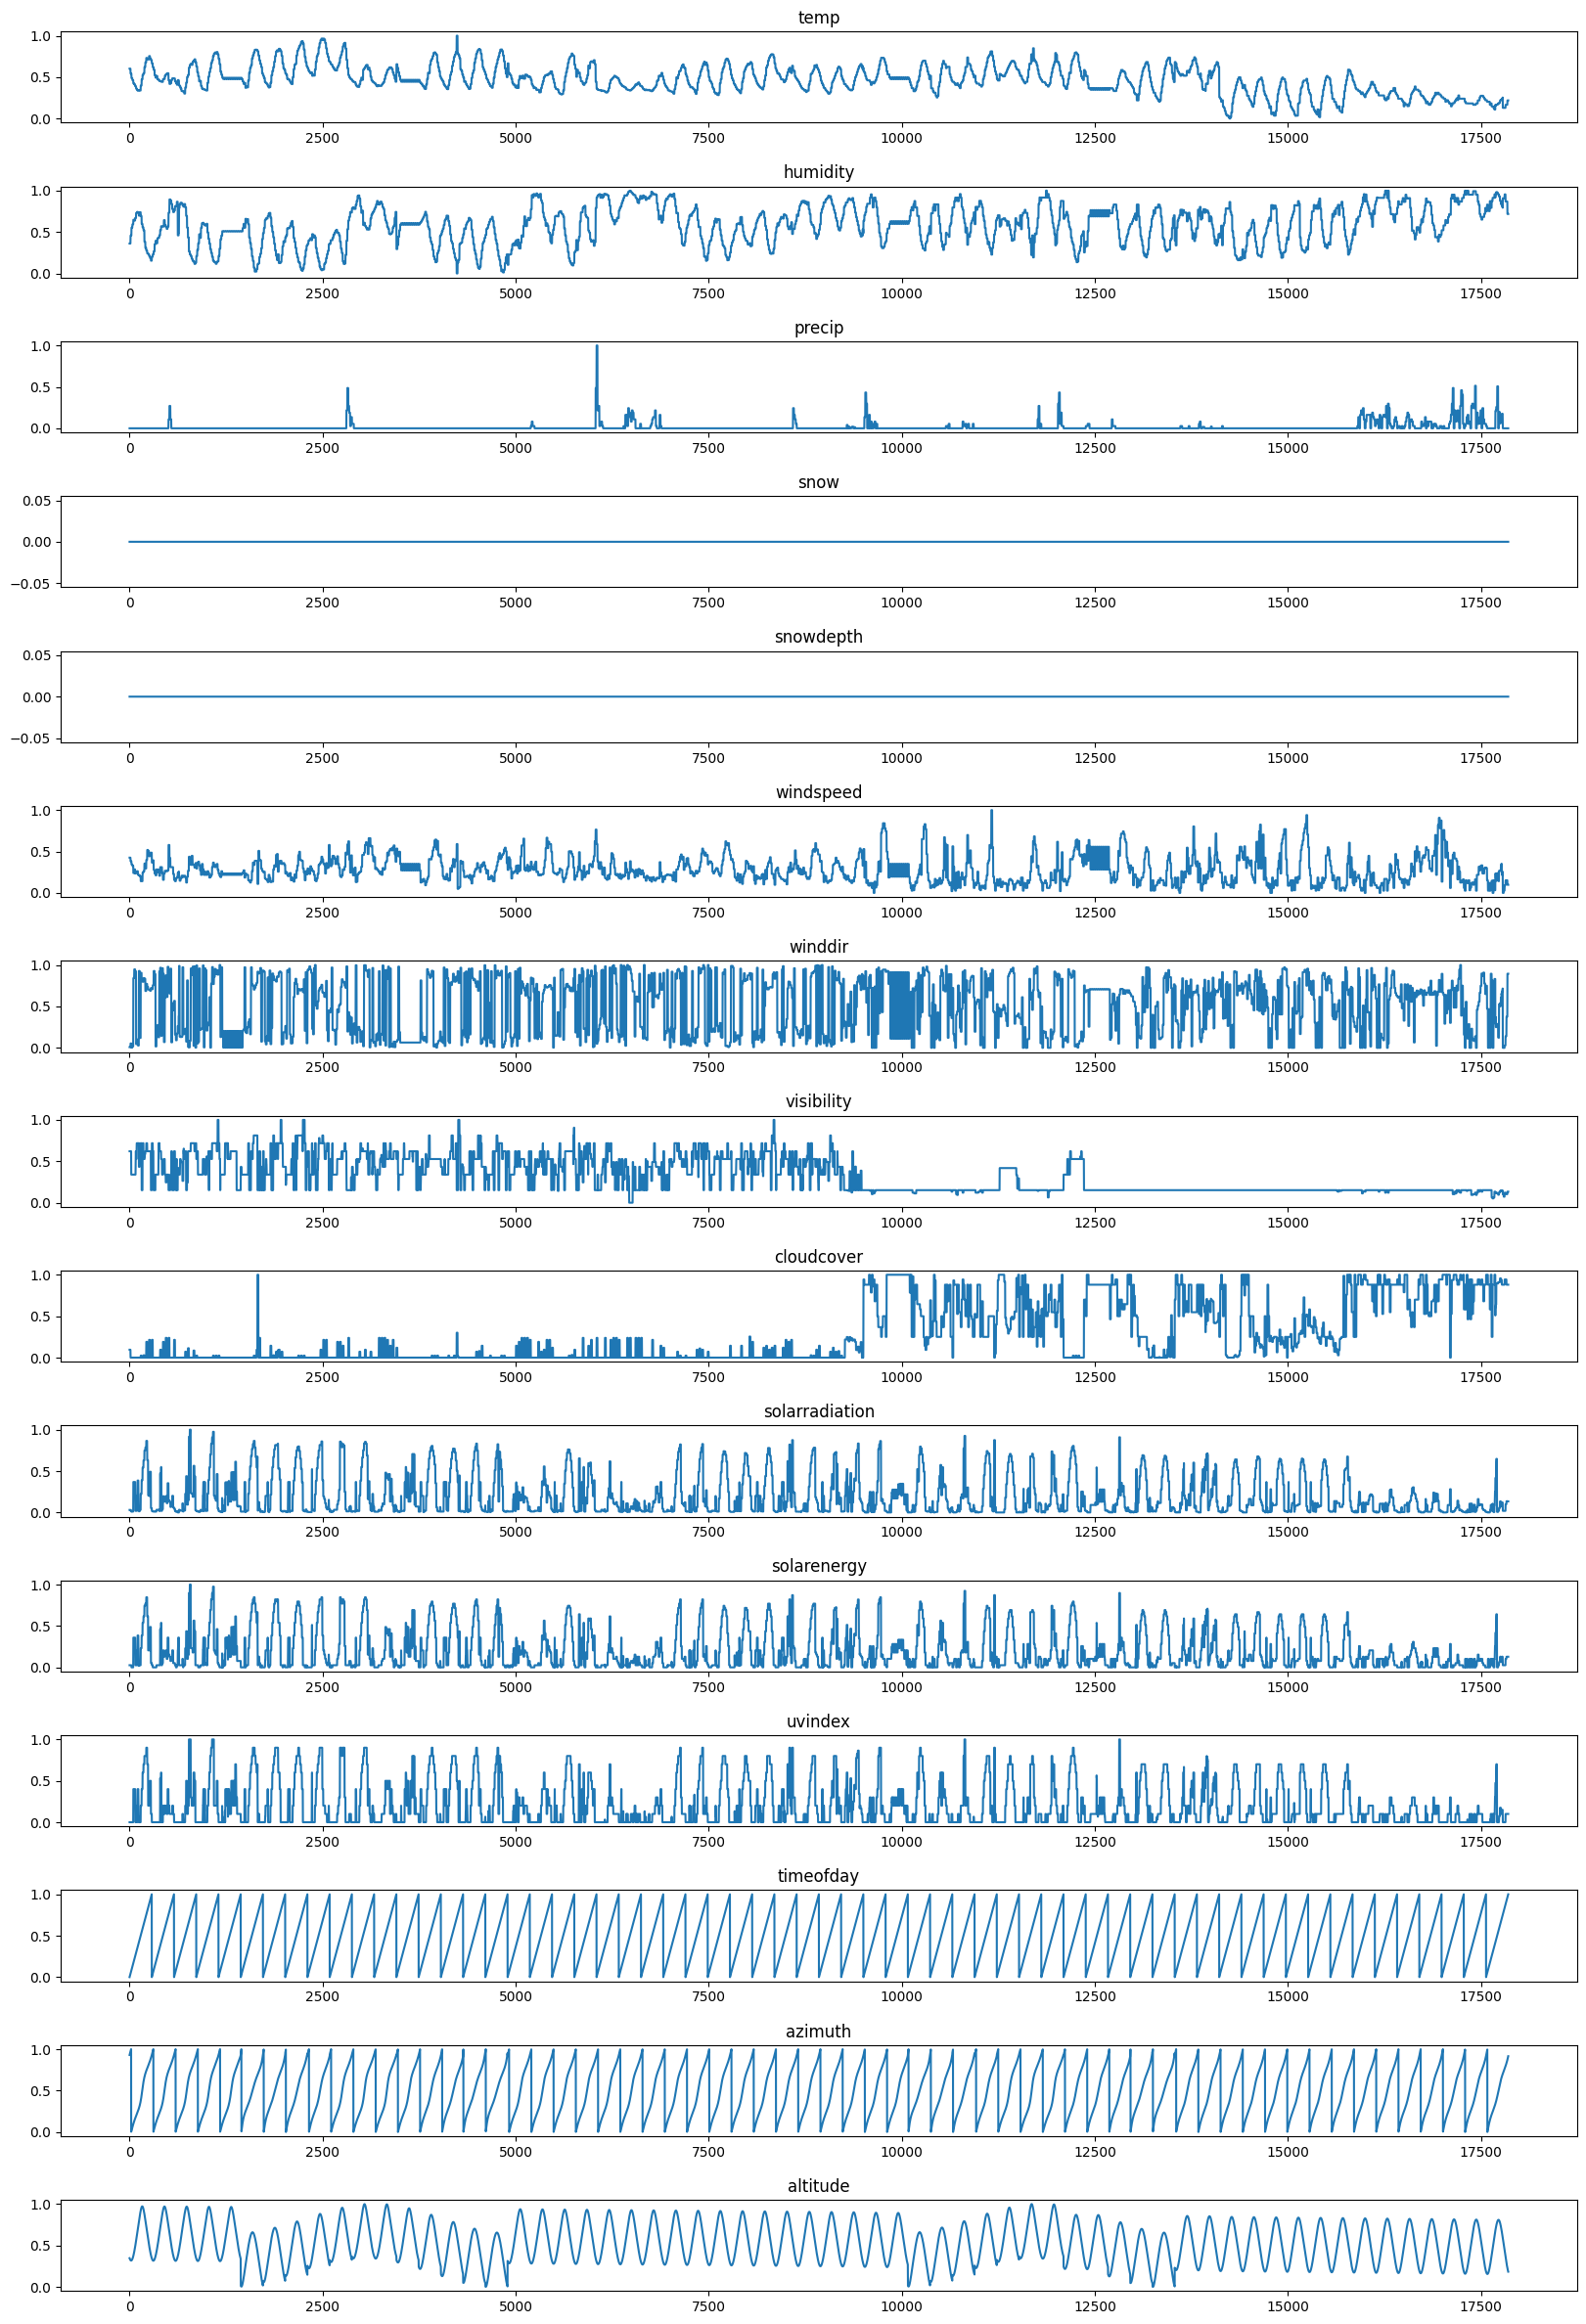

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import suncalc

analyses=[]

df_numerical = x
fig, axs = plt.subplots(len(df_numerical.keys()), figsize=(20, 15))
plt.subplots_adjust(hspace=0.7, wspace=0.3)
i = 0
for key in df_numerical.keys():
    col = df_numerical[key]
    analyse = {"key": key, "min": col.min(), "max": col.max(), "mean": col.mean(), "var": col.var(),
               "nb_nan": col.isna().sum()}
    analyses.append(analyse)
    axs[i].set_title(key)
    axs[i].plot(df_numerical[key])
    i += 1
analyses = pd.DataFrame(analyses)
analyses